## Do it! Natural Language Processing using BERT and GPT - part7
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 7. 질문에 답하기
### 7.1 질의응답 모델 훑어보기

#### 질의응답 : 질문에 답을 하는 과제

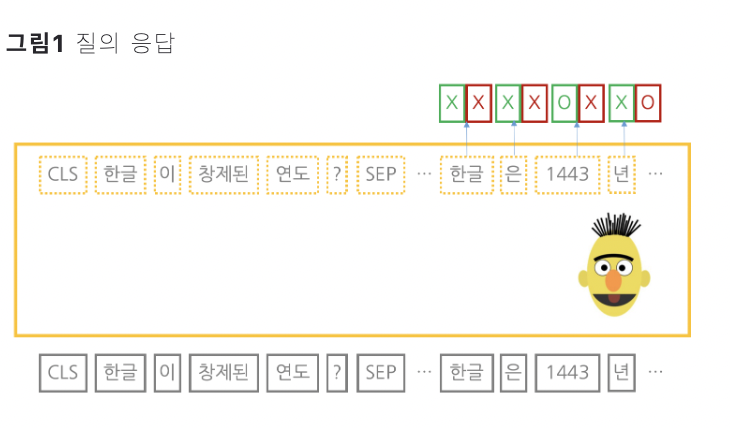
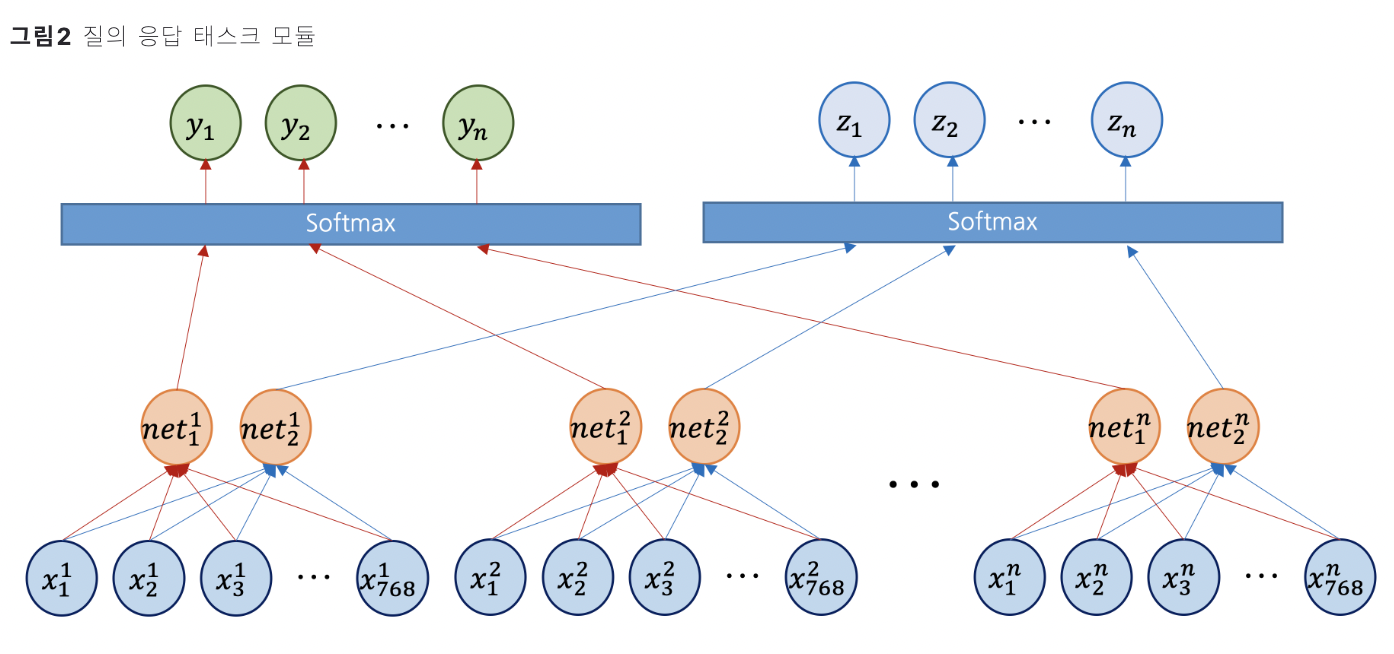

### 7.2 질의응답 모델 학습하기

In [ ]:
#### 모델 환경 설정
import torch 
from ratsnlp.nlpbook.qa import QATrainArguments
args = QATrainArguments(pretrained_model_name = 'beomi/kcbert-base',
                       downstream_corpus_name = 'korquad-v1',
                       downstream_model_dir= './part4-model',
                       max_seq_length = 128, 
                       max_query_length = 32,
                       doc_stride = 64,
                       batch_size = 32 if torch.cuda.is_available() else 4,
                       learning_rate=5e-5,
                       epochs=3,
                       tpu_cores=0 if torch.cuda.is_available() else 8,
                       seed =7)

#### 랜덤 시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

#### 로거 설정
nlpbook.set_logger(args)

#### 말뭉치 다운로드
nlpbook.download_downstream_dataset(args)

#### 토크나이저 준비
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name,
                                         do_lower_case = False)

#### 학습 데이터셋 구축
from ratsnlp.nlpbook.qa import KorQuADV1Corpus, QADataset
corpus = KorQuADV1Corpus()
train_dataset = QADataset(args=args,
                         corpus=corpus,
                         tokenizer=tokenizer,
                         mode = 'train')

#### 학습 데이터 로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(train_dataset,
                             batch_size=args.batch_size,
                             sampler = RandomSampler(train_dataset, replacement=False),
                             collate_fn=nlpbook.data_collator,
                             drop_last=False,
                             num_workers=args.cpu_workers)

#### 평가용 데이터 로더 구축
from torch.utils.data import SequentialSampler
val_dataset = QADataset(args=args,
                       corpus=corpus,
                       tokenizer=tokenizer,
                       mode ='val')
val_dataloader = DataLoader(val_dataset, 
                           batch_size=args.batch_size,
                           sampler=SequentialSampler(val_dataset),
                           collate_fn=nlpbook.data_collator,
                           drop_last =False,
                           num_workers=args.cpu_workers)

#### 모델 초기화
from transformers import BertConfig, BertForQuestionAnswering
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name)
model = BertForQuestionAnswering.from_pretrained(args.pretrained_model_name,
                                                config=pretrained_model_config)

#### 태스크 정의
from ratsnlp.nlpbook.qa import QATask
task = QATask(model, args)

#### 트레이너 정의
trainer = nlpbook.get_trainer(args)

#### 학습 개시
trainer.fit(task, train_dataloader=train_dataloader,
           val_dataloader=val_dataloader)

### 7.3 학습 마침 모델을 실전 투입하기

In [ ]:
#### 인퍼런스 설정
from ratsnlp.nlpbook.qa import QADeployArguments
args = QADeployArguments(pretrained_model_name = 'beomi/kcber-base',
                        downstream_model_dir = './part4-model',
                        max_seq_length = 128,
                        max_query_length = 32)

#### 토크나이저 로드
from transformers import BertTokenizerk
tokenizer = BertTokenizerk.from_pretrained(args.pretrained_model_name,
                                          do_lower_case = False)

#### 체크포인트 로드
import torch
fine_tuned_model_ckpt = torch.load(args.downstream_model_checkpoint_fpath,
                                  map_location = torch.device('cpu'))

#### Bert 설정 로드
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name)

#### Bert 모델 초기화
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering(pretrained_model_config)

#### 체크포인트 주입하기
model.load_state_dict({k.replace('model.', ''): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

#### 평가 모드
model.eval()

#### 인퍼런스
def inference_fn(question, context):
    if question and context:
        truncated_query = tokenizer.encode(question, 
                                          add_special_tokens=False,
                                          truncation=True,
                                          max_length=args.max_query_length)
        inputs = tokenizer.encode_plus(text=truncated_query,
                                      text_pair=context,
                                      truncation='only_second',
                                      padding='max_length',
                                      max_length=args.max_seq_length,
                                      return_token_type_ids=True)
        
        with torch.no_grad():
            outputs = model(**{k:torch.tensor([v]) for k,v in inputs.items()})
            start_pred = outputs.start_logits.argmax(dim=-1).item()
            pred_text = tokenizer.decode(inputs['input_ids'][start_pred:end_pred+1])
    
    else:
        pred_text = ""
        
    return {
        'question' : question,
        "context" : context,
        "answer" : pred_text
    }